IMPORTS

In [13]:
import sys
import os
import torch.cuda
import cv2
import torch
import matplotlib.pyplot as plt
sys.path.append("/notebooks")
print(sys.path)
from tracker.tracker_expert import TrackerExpert 
from PIL import Image

os.environ['ARANGO_HOST']='172.83.9.249'
tracker_expert = TrackerExpert()

['/notebooks/tracker/common/../..', '/notebooks/notebooks', '/opt/conda/lib/python39.zip', '/opt/conda/lib/python3.9', '/opt/conda/lib/python3.9/lib-dynload', '', '/opt/conda/lib/python3.9/site-packages', '/notebooks/tracker/autotracker/detection_models/detectron/detectron2', '/opt/conda/lib/python3.9/site-packages/IPython/extensions', '/root/.ipython', '/root/.local/lib/python3.9/site-packages', '/notebooks', '/notebooks/nebula3_experts', '/notebooks/nebula3_experts/nebula3_pipeline', '/notebooks/nebula3_experts/nebula3_pipeline/nebula3_database', '/notebooks/nebula3_experts/experts', '/notebooks/nebula3_experts', '/notebooks/nebula3_experts/nebula3_pipeline', '/notebooks/tracker/autotracker', '/notebooks/tracker/autotracker/tracking/../../..', '/notebooks', '/notebooks', '/notebooks']
The device is initialized with: cpu.
loading model


Check GPU available

In [7]:
if torch.cuda.is_available():
    print("CUDA is available :D")
else:
    print("CUDA isn't available :(")


CUDA isn't available :(


In [3]:

# from arango import ArangoClient
# client = ArangoClient(hosts='http://ec2-18-158-123-0.eu-central-1.compute.amazonaws.com:8529')
# dbname = 'nebula_development'
# db_manual = client.db(dbname, username='nebula', password='nebula')
# print(db_manual)

['/workspaces/NEBULA2/experts/depth/../common/../..', '/workspaces/NEBULA2/experts/depth', '/opt/conda/lib/python39.zip', '/opt/conda/lib/python3.9', '/opt/conda/lib/python3.9/lib-dynload', '', '/opt/conda/lib/python3.9/site-packages', '/opt/conda/lib/python3.9/site-packages/IPython/extensions', '/root/.ipython', '/root/.local/lib/python3.9/site-packages', '/workspaces/NEBULA2/experts/depth/..', '/workspaces/NEBULA2']
http://ec2-18-158-123-0.eu-central-1.compute.amazonaws.com:8529/


Load Module and Image

In [25]:
# load model
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

# Load transforms to resize and normalize the image for large or small model
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-midas-501f0c75.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid-midas-501f0c75.pt
100%|██████████| 470M/470M [01:05<00:00, 7.52MB/s] 
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [18]:
def get_movie_scene_frames(movie_meta, object_data):
    print(movie_meta)
    mdfs = movie_meta['mdfs']
    # get the bboxes, description for each frame in mdfs per scene
    for scene in mdfs:
        print(scene)

Get movie info

In [23]:
arango_id = "Movies/308486"
scene_element = 0
movie_fetched = tracker_expert.download_video_file(arango_id)
movie = tracker_expert.movie_db.get_movie(arango_id)
print(movie)
frame_numbers = movie['mdfs'][scene_element]
frames = tracker_expert.divide_movie_into_frames(frame_numbers)



http://74.82.28.99:9000/msrvtt/video7100.mp4
{'_key': '308486', '_id': 'Movies/308486', '_rev': '_eTwXd4O--O', 'File': 'video7100', 'url_path': 'http://74.82.28.99:9000/msrvtt/video7100.mp4', 'scenes': [[0, 250]], 'scene_elements': [[0, 250]], 'mdfs': [[22, 156, 246]], 'meta': {'width': 320, 'height': 240, 'fps': 25}, 'updates': 1, 'source': 'msrvtt'}


Predict Depth

In [16]:
# Predict and resize to original resolution
def get_frame_depth(input_batch):
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    return output

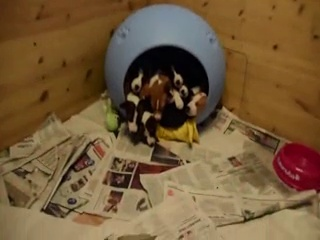

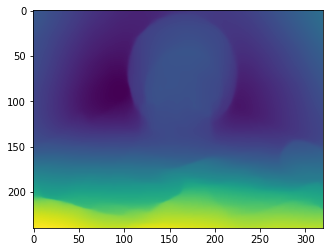

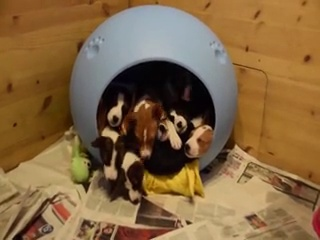

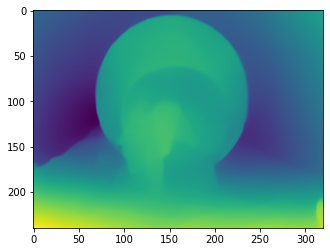

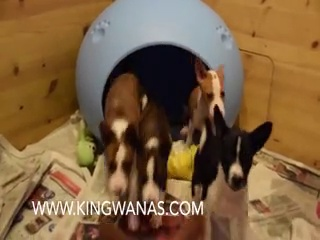

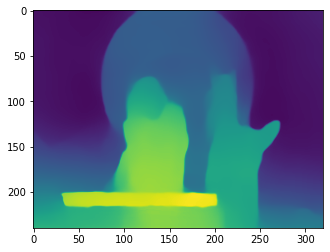

In [26]:
    
# show results
# plt.imshow(output)
# plt.show()
depths = []
cur_frame_no = 0
for frame_file in frames:
    _img = Image.open(frame_file)
    _img.show()
    img = cv2.imread(frame_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # transform
    input_batch = transform(img).to(device)
    depth = get_frame_depth(input_batch)
    if len(depth):
        depths.append({frame_numbers[cur_frame_no]: depth })
        plt.imshow(depth)
        plt.show()

    cur_frame_no += 1